In [87]:
import pandas as pd
import pymc as pm
from pymc import distributions as dist
import arviz as az

df = pd.read_csv('./data/fm_data.csv')
df.columns

Index(['team', 'merge_name', 'season', 'playerId', 'name', 'position',
       'games_played', 'icetime', 'faceoffsWon', 'penalityMinutes',
       'shotsBlockedByPlayer', 'I_F_points', 'I_F_dZoneGiveaways', 'I_F_hits',
       'AGE', 'TYPE', 'EXTENSION', 'SIGNING AGE', 'LENGTH', 'SALARY', 'Team',
       'State/Prov', 'Country', 'Conference', 'Division', 'O6', 'EffTaxRate',
       'L_Salary', 'xGoals_diff', 'faceoffsWon_per60', 'penalityMinutes_per60',
       'shotsBlockedByPlayer_per60', 'I_F_points_per60',
       'I_F_dZoneGiveaways_per60', 'I_F_hits_per60', 'xGoals_diff_per60'],
      dtype='object')

In [113]:
categorical_indices = {}
player_indices = {}

# df['team'].factorize()
for var in ['team', 'name', 'position', 'Country', 'TYPE', 'EXTENSION', 'O6']:
    player_cat_index, cat_values = df[var].factorize()
    categorical_indices.update({var: cat_values.values})
    player_indices.update({var: player_cat_index})

# 
coords = categorical_indices


In [132]:

categorical_uniques = pd.DataFrame(player_indices).merge(df['EffTaxRate'], left_index=True, right_index=True)
cdf = categorical_uniques[['team', 'Country', 'O6', 'EffTaxRate']].drop_duplicates()
cdf


,team,Country,O6,EffTaxRate
0,0,0,0,0.466
162,1,0,0,0.412
303,2,0,1,0.415
455,3,0,0,0.432
605,4,0,0,0.420
740,5,0,0,0.431
889,6,1,0,0.451
1045,7,0,1,0.415
1167,8,0,0,0.414
1323,9,0,0,0.375


In [384]:
X = df[['xGoals_diff', 'faceoffsWon_per60', 'penalityMinutes_per60',
       'shotsBlockedByPlayer_per60', 'I_F_points_per60',
       'I_F_dZoneGiveaways_per60', 'I_F_hits_per60', 'xGoals_diff_per60']]
from pytensor.tensor.math import sum as tensor_sum
with pm.Model(coords=coords) as model:

    # type_salary = pm.Normal('type_salary', 11, 3, dims='TYPE')
    # type_sigma = pm.Exponential('type_sigma', 5, dims='TYPE')

    # position_diff = pm.Normal('position_diff', mu=0, sigma=1, dims=['position', 'TYPE'])
    # print(pm.draw(position_diff)) 
    # print(pm.draw(type_sigma))
    # print(pm.draw(type_salary))
    # position_sigma = pm.HalfNormal('position_sigma', 5, dims=['position', 'TYPE'])
    # position_mu = pm.Deterministic('position_mu', type_salary + position_diff*type_sigma, dims=['position', 'TYPE'])
    # position_salary = pm.Normal('position_salary', type_salary + position_diff * position_sigma, 3, dims=('position', 'TYPE'))

    # team specific variables
    # indicator_vars = pm.Normal('country_beta', 0, 3, dims=('Country', 'TYPE'))
    # tax_beta = pm.Normal('tax_beta', 0, 3)

    # team_intercept = dist.Normal('team_intercept', position_salary, 3, dims=('team', 'position', 'TYPE'))
    # print(pm.draw(team_intercept).shape)
    # print(pm.draw(tax_beta * cdf['EffTaxRate']).shape)
    # print(pm.draw(indicator_vars[cdf['Country']]).shape)

    # team_effect = team_intercept.dimshuffle(2, 1, 0) + (tax_beta * cdf['EffTaxRate']) #+ indicator_vars[cdf['Country']].dimshuffle(1, 0)
    # team_effect = (team_effect.dimshuffle(1, 0, 2) + indicator_vars[cdf['Country']].T).dimshuffle(2, 0, 1)
    # team_alpha = pm.Deterministic('team_alpha', team_effect)

    # print(pm.draw(indicator_vars[cdf['Country']]).T.shape)
    # print(pm.draw(team_alpha.shape))
    # print(pm.draw(team_alpha.dimshuffle(1, 0, 2).shape))

    # print( + indicator_vars[cdf['Country']]).T)


    # team_indicator_effect = indicator_vars[cdf['Country']] + tax_beta*cdf['EffTaxRate'] 

    # team_mu = position_salary + team_indicator_effect
    # team_salary = pm.Normal('team_salary', team_mu, 3, dims = ('team', 'position', 'TYPE'))

    # salary_alpha = team_salary[player_indices['team'], player_indices['position'], player_indices['TYPE']] 
    # indicator_effects = team_indicator_effect[player_indices['team'], player_indices['TYPE']] 

    # contract_est = team_alpha[player_indices['team'], player_indices['position'], player_indices['TYPE']]
    salary_sigma = pm.Exponential('salary_sigma', 5, dims=['TYPE'])

    alpha = pm.Normal('alpha', 10, 3, dims='TYPE')

    beta = pm.Normal('beta', 0, 3, shape=(2, X.shape[1]), dims='TYPE')
    linear_effect = (X * beta[player_indices['TYPE']])
    contract_est = alpha[player_indices['TYPE']] + linear_effect

    y = pm.Cauchy('log_salary', alpha=contract_est, beta=salary_sigma[player_indices['TYPE']], observed = df['L_Salary'])

pm.model_to_graphviz(model)


TypeError: TensorType does not support iteration. Maybe you are using builtins.sum instead of pytensor.tensor.math.sum? (Maybe .max?)

In [381]:
linear_effect = (X * tmp[player_indices['TYPE']]).sum(axis=1)

0       -12.653150
1        96.887535
2       114.222741
3       119.462730
4       113.027741
           ...    
4602    -19.416134
4603    -22.494748
4604     -1.135748
4605   -104.287512
4606    -70.057980
Length: 4607, dtype: float64

In [353]:

with model:
    trace = pm.sample(1000)

# model.profile(model.logp).summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [global_mu, global_sigma, position_offset, salary_sigma]


ValueError: Not enough samples to build a trace.

array([[<Axes: title={'center': 'type_salary'}>,
        <Axes: title={'center': 'type_salary'}>],
       [<Axes: title={'center': 'pos_diff'}>,
        <Axes: title={'center': 'pos_diff'}>],
       [<Axes: title={'center': 'type_sigma'}>,
        <Axes: title={'center': 'type_sigma'}>],
       [<Axes: title={'center': 'salary_sigma'}>,
        <Axes: title={'center': 'salary_sigma'}>],
       [<Axes: title={'center': 'position_salary'}>,
        <Axes: title={'center': 'position_salary'}>]], dtype=object)

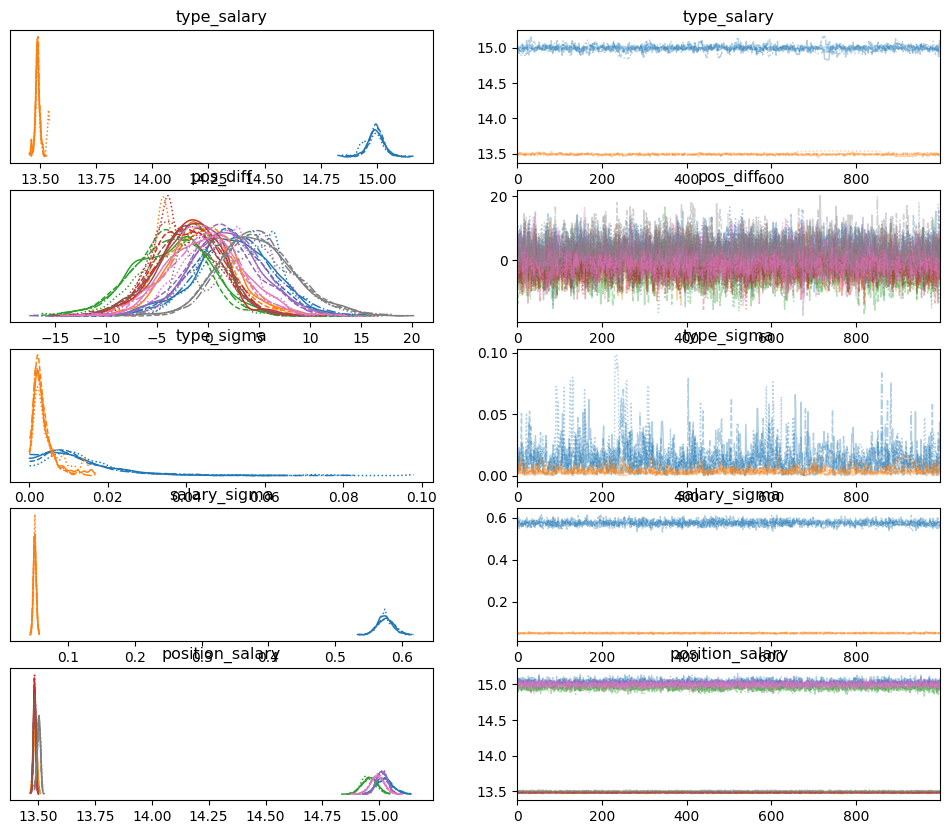

In [341]:
# az.plot_trace(trace.posterior, coords={'TYPE': ['Standard (1-way)', 'Standard (2-way)'], 'team': ['BOS', 'TBL'], 'position': ['C']})
az.plot_trace(trace.posterior)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

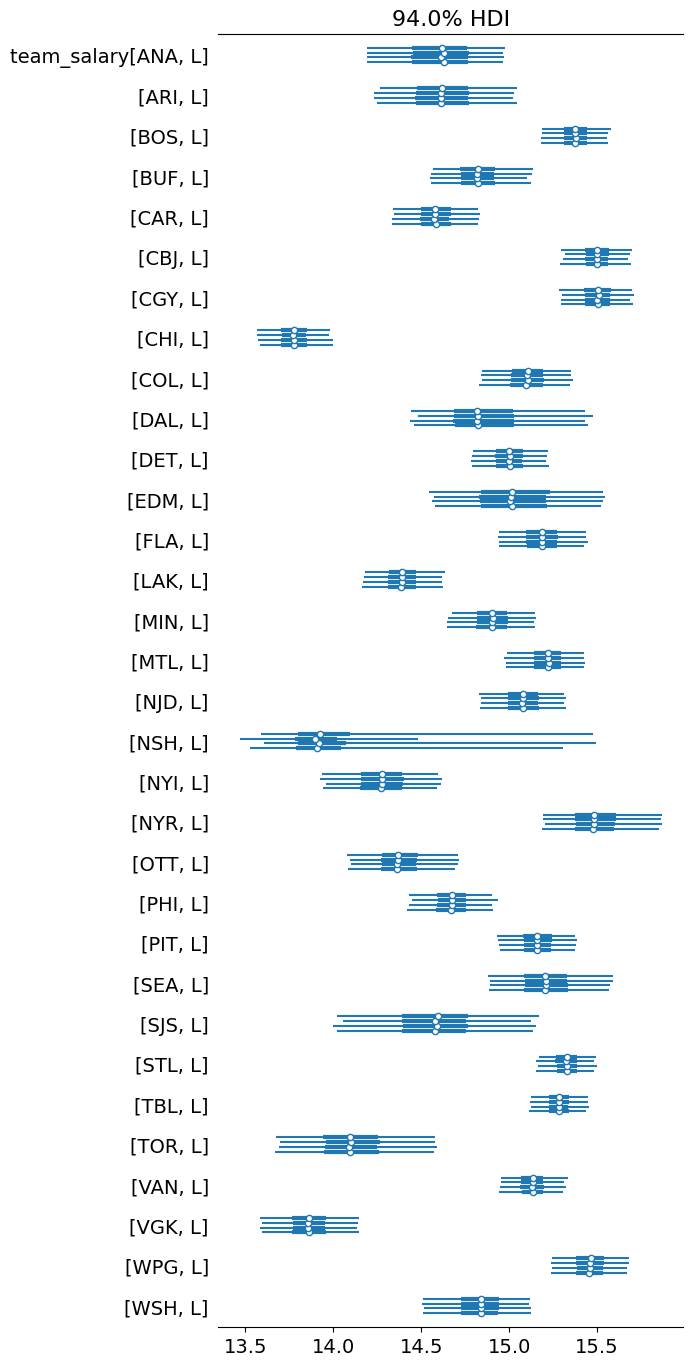

In [110]:
az.plot_forest(trace, coords={'TYPE': 'Standard (1-way)', 'position': ['L']}, var_names=['team_salary'])